# Importing Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from numpy import random
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import statsmodels.api as sm 
from numpy import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from random import randint
from itertools import chain
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Essential Functions

In [2]:
##Faults:
# 1. Offset Fault: x' = a + x + err
# 2. Gain Fault: x' = Bx+ err
# 3. Stuck at Fault: x' = a
# 4. Out-of-bound: x'<theta1 and x'>theta2

#Function to simulate fault
def simulateFault(sensedValues,params):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index/4
    BMS = []
    classification = []
    
    noise = random.rand(len(sensedValues)) * 0
    for i in range(0, len(sensedValues)):
        if i <= interval:
            a = params['constant']
            sign = random.randint(1,3)
            if sign == 1:
                BMS.append(noise[i] + a + sensedValues[i])
            else:
                BMS.append(-noise[i] + a + sensedValues[i])
            classification.append(1)

        elif i > interval and i <= interval*2:
            B = params['coeff']
            sign = random.randint(1,3)
            #print('goes here1')
            if sign == 1:
                BMS.append(noise[i] + B * sensedValues[i])
            else:
                BMS.append(noise[i] + B * sensedValues[i])
            classification.append(1)

        elif i > interval*2 and i<= interval*3:
            a = params['stuck']
            #print('goes here2')
            BMS.append(a)
            classification.append(1)
            
        elif i > interval*3 and i<= interval*4:
            #print('goes here3')
            type_fault = random.randint(1,3)
            low_bound = params['bounds'][0]
            up_bound = params['bounds'][1]
            if type_fault == 1:
                BMS.append(low_bound-noise[i])
            else:
                BMS.append(up_bound + noise[i])
            classification.append(1)
        else:
            #print('goes here4')
            BMS.append(noise[i] + sensedValues[i])
            classification.append(0)

    BMS = np.array(BMS)
    BMS = BMS.round(decimals = 3)
    sensedValues = sensedValues.round(decimals=3)
    return np.array(BMS), np.array(classification)

def simulateSpecificFault(sensedValues, params, value):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index
    BMS = []
    classification = []
    
    #noise = random.rand(len(sensedValues)) * 0
    
    for i in range(0, len(sensedValues)):
        if i < interval:
            if params == 'constant':
                a = value
                #sign = random.randint(1,3)
                #print('goes here')
                #if sign == 1:
                BMS.append(a + sensedValues[i])
                #else:
                #    BMS.append(noise[i] - a + sensedValues[i])
                classification.append(1)

            elif params == 'gain':
                B = value 
                sign = random.randint(1,3)
                if sign == 1:
                    BMS.append(B * sensedValues[i])
                else:
                    BMS.append(B * sensedValues[i])
                classification.append(1)

            elif params == 'stuck':
                a = value
                BMS.append(a)
                classification.append(1)
            
            elif params == 'bounds':
                half_point = interval/2
                if i < half_point:
                    x = random.randint(273, 289)
                    BMS.append(x)
                else:
                    x = random.randint(303, 323)
                    BMS.append(x)
                classification.append(1)
        else:
            BMS.append(sensedValues[i])
            classification.append(0)

    BMS = np.array(BMS)
    BMS = BMS.round(decimals = 3)
    sensedValues = sensedValues.round(decimals=3)
    return np.array(BMS), np.array(classification)

#Function to generate noise
def generateNoise(noise, values):
    noisy_data = []
    for i in range(0,len(values)):
        noisy_data.append(values[i]+random.uniform(-noise,noise))
    return noisy_data

#Function to define vectors for regression model
def define_vectors(vals):
    x1 = []
    x2 = []
    x = []
    y = []
    for i in range(1,len(vals)):
        lhs_term1 = 20.52*240*(vals['zone_temp'][i]-vals['zone_temp'][i-1])/300
        lhs_term2 = 1005*(vals['supply_temp'][i]-vals['zone_temp'][i])*vals['air_flow'][i]
        lhs_term3 = 100 * vals['occupancy'][i]
        c = lhs_term1 - lhs_term2 - lhs_term3
        y.append(c)
        #x1.append(100)
        x2.append((vals['outdoor_temp'][i]-vals['zone_temp'][i]))
    inputs = {'x2':x2}
    output = {'y':y}
    return inputs, output

def perform_classification(err, bounds):
    
    j = 0
    
    while j <= err:
        
        true_fault = []

        for i in range(0,len(bounds)):
            if bounds['zone_temp'][i] > (bounds['pred'][i] + j) or bounds['zone_temp'][i] < (bounds['pred'][i] - j):
                true_fault.append(1)
            else:
                true_fault.append(0)
                
        bounds['predClass'] = true_fault
        
        j = j + 0.1
                
    bounds['predClass'] = true_fault
    
    return bounds

def compute_TPR_FPR(err, bounds, temporal_difference):
    tpr = []
    fpr = []
    j = 0
    while j <= err*5:
        
        true_fault = []

        for i in range(0,len(bounds)):
            if bounds['zone_temp'][i] > (bounds['pred'][i] + j) or bounds['zone_temp'][i] < (bounds['pred'][i] - j):
                true_fault.append(1)
            else:
                if bounds['lag_1'][i] == bounds['lag_2'][i] and bounds['lag_1'][i] == bounds['lag_3'][i]:
                    true_fault.append(1)
                else:
                    true_fault.append(0)
        bounds['predClass'] = true_fault

        fp = np.sum((bounds['predClass'] == 1) & (bounds['classification'] == 0))
        tp = np.sum((bounds['predClass'] == 1) & (bounds['classification'] == 1))

        fn = np.sum((bounds['predClass'] == 0) & (bounds['classification'] == 1))
        tn = np.sum((bounds['predClass'] == 0) & (bounds['classification'] == 0))

        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))
        
        j = j + 0.1
    
    return tpr, fpr

def prepare_temporal_difference_vector(vector):
    
    vector['lag_1'] = vector['zone_temp'].shift(1)
    vector['lag_2'] = vector['zone_temp'].shift(2)
    vector['lag_3'] = vector['zone_temp'].shift(3)
    
    vector = vector[['lag_1', 'lag_2', 'lag_3']]
    vector = vector.dropna()
    
    print(vector)
    return vector

def calculate_zone_temp(resistance, thermal, vals):
    
    pred_array = []
    true_array = []

    for i in range(1,len(vals)):
        result = 0
        
        rhs = 16.42 * vals['zone_temp'][i-1] + 1005 * vals['supply_temp'][i]*vals['air_flow'][i] +100 *(vals['occupancy'][i]+thermal) + resistance * vals['outdoor_temp'][i]
        lhs = 16.42 + 1005*vals['air_flow'][i] + resistance
        result = rhs/lhs

        pred_array.append(result)
        true_array.append(vals['zone_temp'][i])
    
    return pred_array, true_array

def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

def create_LSTM_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(1,4), return_sequences=True))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(4, activation = 'relu'))
    model.add(Dense(2, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

# Initializing dataset

In [3]:
data = pd.read_csv('data/result.csv',parse_dates=['time'], index_col=['time'])
data['outdoor_temp'] = data['outdoor_temp'] + 273
data['zone_temp'] = data['zone_temp'] + 273
data['supply_temp'] = data['supply_temp'] + 273
data

,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
time,,,,,
2017-01-01 00:00:00,275.200,295.832449,0,298.000003,0.733767
2017-01-01 00:05:00,274.825,295.824465,0,298.000003,0.733767
2017-01-01 00:10:00,274.450,295.812760,0,298.000003,0.733767
2017-01-01 00:15:00,274.075,295.799019,0,298.000003,0.733767
2017-01-01 00:20:00,273.700,295.784421,0,298.000003,0.733767
...,...,...,...,...,...
2017-12-31 23:40:00,279.000,295.990503,0,298.000004,0.733767
2017-12-31 23:45:00,279.000,295.988552,0,298.000004,0.733767
2017-12-31 23:50:00,279.000,295.986715,0,298.000004,0.733767


# Initializing Training and Validation dataset

In [4]:
train = data.loc['2017-03-13 00:00:00':'2017-03-19 23:55:00'] #data[53086:53089]
inputs, output = define_vectors(train)

inputs = pd.DataFrame(data = inputs)
output = pd.DataFrame(data = output)

errType = 'constant'

test = data.loc['2017-03-27 00:00:00':'2017-04-09 23:55:00'] #data[end_index-1:end_index + 10]
test = test.reset_index()
test['supply_temp'],test_label = simulateSpecificFault(test['supply_temp'], errType, 0)
#test_label = test_label[3:]
inputs_test, output_test = define_vectors(test)
temporal_difference = prepare_temporal_difference_vector(test)
temporal_difference = temporal_difference.reset_index()

inputs_test = pd.DataFrame(data = inputs_test)
output_test = pd.DataFrame(data = output_test)

           lag_1       lag_2       lag_3
3     296.261866  296.267802  296.274594
4     296.256423  296.261866  296.267802
5     296.251218  296.256423  296.261866
6     296.246165  296.251218  296.256423
7     296.241255  296.246165  296.251218
...          ...         ...         ...
4027  296.697421  296.702011  296.706717
4028  296.692963  296.697421  296.702011
4029  296.688636  296.692963  296.697421
4030  296.684438  296.688636  296.692963
4031  296.680369  296.684438  296.688636

[4029 rows x 3 columns]


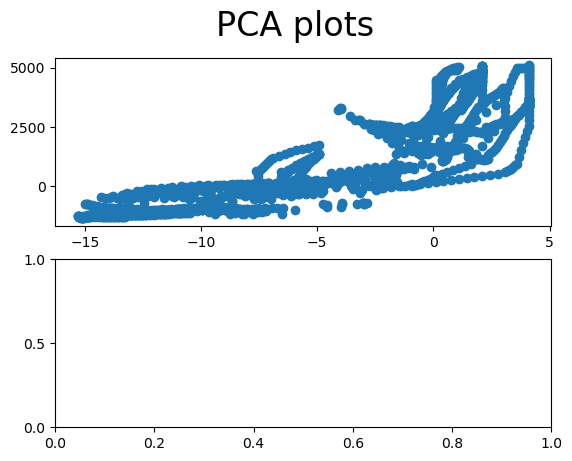

In [5]:
fig, axs = plt.subplots(2)
plt.rcParams.update({'font.size': 20})
fig.suptitle('PCA plots')
#axs[0].scatter(inputs['x1'], output['y'])
axs[0].scatter(inputs['x2'], output['y'])
plt.show()

In [6]:
scaler = StandardScaler()
scaler1 = StandardScaler()
inputs_scaled = scaler.fit_transform(inputs)
output_scaled = scaler1.fit_transform(output)
inputs_test_scaled = scaler.transform(inputs_test)

[[-1.23028525]
 [-1.21500364]
 [-1.1999965 ]
 ...
 [-0.87941362]
 [-0.89222191]
 [-0.90504237]]


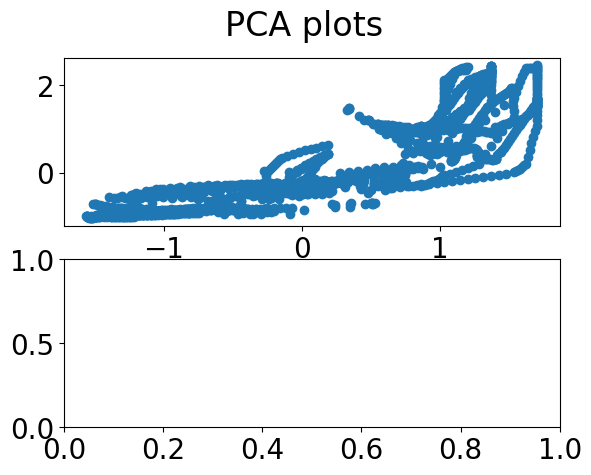

In [7]:
print(inputs_scaled)
fig, axs = plt.subplots(2)
plt.rcParams.update({'font.size': 20})
fig.suptitle('PCA plots')
#axs[0].scatter(inputs['x1'], output['y'])
axs[0].scatter(inputs_scaled, output_scaled)
plt.show()

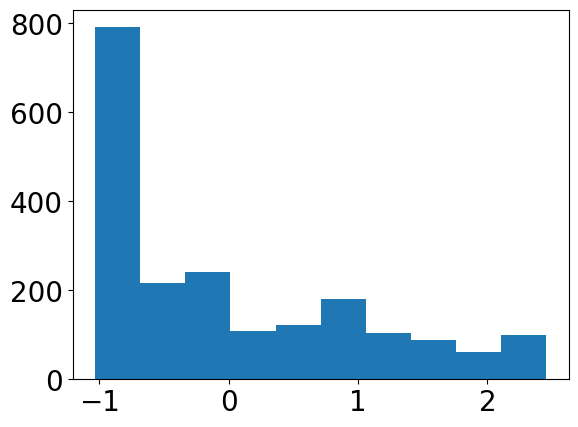

In [8]:
from scipy.stats import boxcox
plt.hist(output_scaled)
plt.show()

# Using OLS regression for fault detection

In [9]:
inputs_with_constant = sm.add_constant(inputs)
model = sm.OLS(output_scaled,inputs_with_constant)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     7100.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        06:18:45   Log-Likelihood:                -1337.7
No. Observations:                2015   AIC:                             2679.
Df Residuals:                    2013   BIC:                             2691.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8976      0.015     60.080      0.000       0.868       0.927
x2             0.1485      0.002     84.263      0.000       0.145       0.152
==============================================================================
Omnibus:                       30.446   Durbin-Watson:                   0.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.427
Skew:                           0.210   Prob(JB):                     4.52e-09
Kurtosis:                       3.531   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
results.params['const']

0.8975814368652743

# Using SVR model for fault detection

In [11]:
regr = SVR(kernel = 'linear', gamma = 0.8, C = 3)
regr.fit(inputs_scaled, output_scaled)
regr.coef_

C:\Users\renat\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0.84411434]])

In [12]:
pred_array, true_array = calculate_zone_temp(results.params['x2'],results.params['const'],train)
# pred_array, true_array = calculate_zone_temp(regr.coef_,regr.intercept_,train)
# pred_array = list(chain.from_iterable(pred_array))
# pred_array = list(chain.from_iterable(pred_array))
# print(pred_array[0:505])
# print(true_array[500:505])
err = np.sqrt(mse(true_array[0:288], pred_array[0:288]))
print(err)

2.8383829260223488


In [13]:
pred_array, true_array = calculate_zone_temp(results.params['x2'],results.params['const'],test)
# pred_array, true_array = calculate_zone_temp(regr.coef_,regr.intercept_,test)
# pred_array = list(chain.from_iterable(pred_array))
# pred_array = list(chain.from_iterable(pred_array))
print(pred_array[50:55])
print(true_array[50:55])
err = np.sqrt(mse(true_array[0:288], pred_array[0:288]))
print(err)

[298.07390992585454, 298.0737810626439, 298.0736452070329, 298.0735090789906, 298.07336963713095]
[296.08145213, 296.07672147, 296.0719783, 296.06708296, 296.06212726]
2.2533128014080255


In [14]:
from sklearn.metrics import r2_score
r2_score(true_array[0:288], pred_array[0:288])

-8.589930393229622

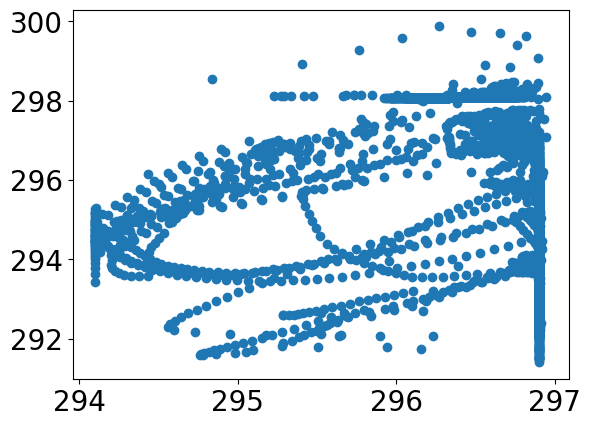

In [15]:
plt.scatter(true_array, pred_array)

# Compute TPR and FPR for ROC curve

In [19]:
upper_bound = []
lower_bound = []

upper_bound = pred_array
lower_bound = pred_array 
bounds = test
bounds = bounds.reset_index()
print(len(bounds))
print(len(upper_bound))
bounds['upper'] = upper_bound + err
bounds['lower'] = lower_bound - err
bounds['pred'] = pred_array
bounds['classification'] = test_label[1:]
bounds = bounds.dropna()
bounds = bounds.reset_index()
bounds = bounds.set_index('time')
bounds

4032
4031


ValueError: Length of values (4031) does not match length of index (4032)

In [173]:
tpr, fpr = compute_TPR_FPR(err, bounds, temporal_difference)

# Generating ROC curve figure

<Figure size 432x288 with 0 Axes>

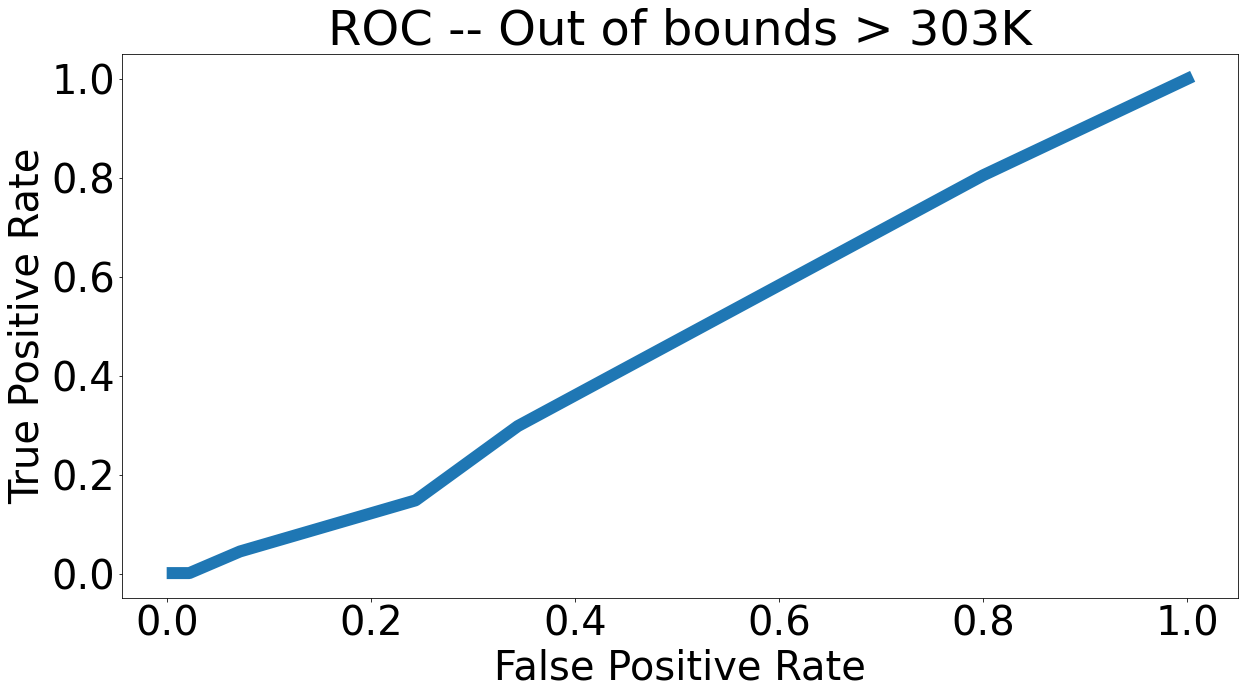

In [174]:
plt.figure()
plt.rcParams.update({'font.size': 40})
plt.figure(figsize=(20,10))
plt.plot(fpr, tpr, linewidth = 12)
plt.xticks(np.arange(0, 1.1, step=0.2))
plt.yticks(np.arange(0, 1.1, step=0.2))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC -- Out of bounds > 303K')
plt.show()

# Fault classification visual (Note: Better used when test data is small)

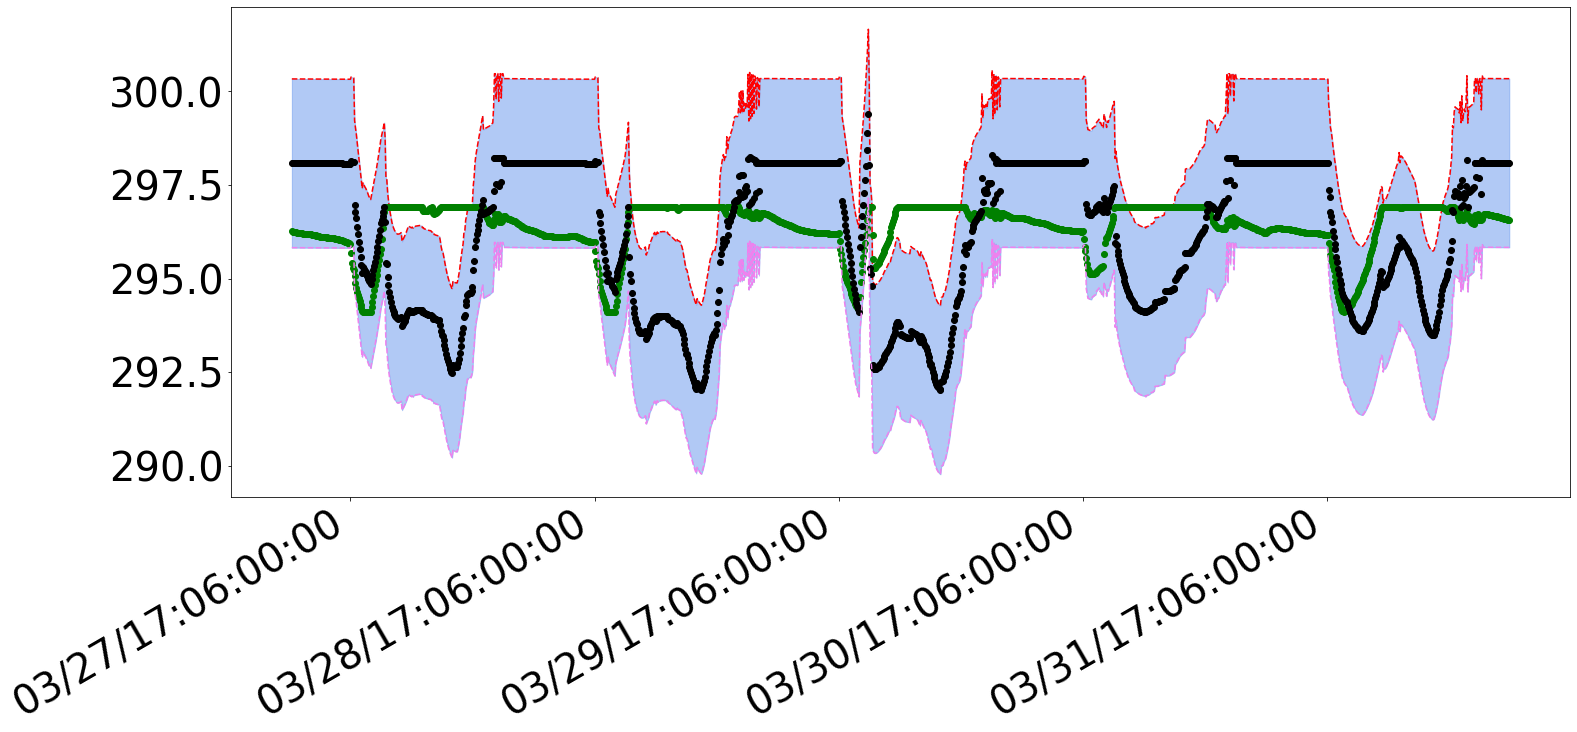

In [181]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()
hours = mdates.HourLocator(interval =24)
h_fmt = mdates.DateFormatter('%D:%H:%M:%S')
subset = bounds.loc['2017-03-27 00:00:00':'2017-03-31 23:55:00']

ax.plot(subset.index, subset['upper'].values, '--', color = 'red', label = 'Upper bound')
ax.plot(subset.index, subset['zone_temp'].values, 'o', color = 'green', label = 'Actual')
ax.plot(subset.index, subset['pred'].values, 'o', color = 'black', label = 'Predicted')
ax.plot(subset.index, subset['lower'].values, '--', color = 'violet', label = 'Lower Bound')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(24, 10)
plt.fill_between(subset.index, subset['upper'].values,subset['lower'].values,color='cornflowerblue',alpha=.5)
plt.show()

# ROC Figure generation script

In [27]:
def physical_model(errType, value):
    tpr_list = []
    fpr_list = []

    for i in range(0,3):

        #load data and preprocess it 

        train = data[0:int(len(data)*0.8)] 
        inputs, output = define_vectors(train)

        inputs = pd.DataFrame(data = inputs)
        output = pd.DataFrame(data = output)

        test = data[int(len(data)*0.8):] 
        test = test.reset_index()
        test['supply_temp'],test_label = simulateSpecificFault(test['supply_temp'], errType, value)
        inputs_test, output_test = define_vectors(test)

        temporal_difference = prepare_temporal_difference_vector(test)
        temporal_difference = temporal_difference.reset_index()

        inputs_test = pd.DataFrame(data = inputs_test)
        output_test = pd.DataFrame(data = output_test)

        scaler = StandardScaler()
        scaler1 = StandardScaler()
        inputs_scaled = scaler.fit_transform(inputs)
        output_scaled = scaler1.fit_transform(output)
        inputs_test_scaled = scaler.transform(inputs_test)

        inputs_with_constant = sm.add_constant(inputs)
        model = sm.OLS(output_scaled,inputs_with_constant)
        results = model.fit()

        pred_array, true_array = calculate_zone_temp(results.params['x2'],results.params['const'],train)
        err = np.sqrt(mse(true_array, pred_array))
        pred_array, true_array = calculate_zone_temp(results.params['x2'],results.params['const'],test)

        upper_bound = []
        lower_bound = []

        upper_bound = pred_array 
        lower_bound = pred_array 
        bounds = test[1:]
        bounds = bounds.reset_index()
        bounds['upper'] = upper_bound + err
        bounds['lower'] = lower_bound - err
        bounds['pred'] = pred_array
        bounds['classification'] = test_label[1:]
        bounds = bounds.dropna()
        bounds = bounds.reset_index()

        tpr, fpr = compute_TPR_FPR(err, bounds, temporal_difference)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

        value = value + value
        
    return tpr_list, fpr_list

def pre_trained_SVM_Classifier():
    acc = []
    offset = []
    gain = []
    stuck = []
    out_bounds = []

    train_data = data[0:int(len(data)*0.8)] 
    
    test_data = data[int(len(data)*0.8):] 
    test_data = test_data.reset_index()

    supply_temp_train = train_data.drop(['outdoor_temp', 'zone_temp','occupancy','air_flow'], axis=1)
    stuck_val = random.randint(16,32)
    print(stuck_val)

    FaultData, classification = simulateFault(supply_temp_train['supply_temp'],{'constant': 10, 'coeff': 1.05, 'stuck': stuck_val, 'bounds': [14,60]})
    supply_temp_train['supply_temp_BMS'] = FaultData
    supply_temp_train['lag_1'] = supply_temp_train['supply_temp'].shift(1)
    supply_temp_train['lag_2'] = supply_temp_train['supply_temp_BMS'].shift(1)
    supply_temp_train['lag_3'] = supply_temp_train['supply_temp'].shift(2)
    supply_temp_train['lag_4'] = supply_temp_train['supply_temp_BMS'].shift(2)
    supply_temp_train['lag_5'] = supply_temp_train['supply_temp'].shift(3)
    supply_temp_train['lag_6'] = supply_temp_train['supply_temp_BMS'].shift(3)
    supply_temp_train = supply_temp_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
    supply_temp_train = supply_temp_train.dropna()
    x_train = supply_temp_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
    y_train = classification[0:len(classification)-3]

    #Create a svm Classifier
    clf = svm.SVC(kernel='rbf', C = 1, gamma = 0.4, probability = True) # Linear Kernel 

    #Train the model using the training sets
    clf.fit(x_train, y_train)
    
    errType = 'constant'
    test_data = data[int(len(data)*0.8):]
    test_data = test_data.reset_index()
    supply_temp_test = test_data.drop(['outdoor_temp', 'zone_temp','occupancy','air_flow'], axis=1)
    stuck_val = random.randint(16,32)

    FaultData, classification = simulateSpecificFault(test_data['supply_temp'], errType, 10)
    supply_temp_test['supply_temp_BMS'] = FaultData
    supply_temp_test['lag_1'] = supply_temp_test['supply_temp'].shift(1)
    supply_temp_test['lag_2'] = supply_temp_test['supply_temp_BMS'].shift(1)
    supply_temp_test['lag_3'] = supply_temp_test['supply_temp'].shift(2)
    supply_temp_test['lag_4'] = supply_temp_test['supply_temp_BMS'].shift(2)
    supply_temp_test['lag_5'] = supply_temp_test['supply_temp'].shift(3)
    supply_temp_test['lag_6'] = supply_temp_test['supply_temp_BMS'].shift(3)
    supply_temp_test = supply_temp_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
    supply_temp_test = supply_temp_test.dropna()
    x_test = supply_temp_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']]
    y_test = classification[0:len(classification)-3]
    x_test = x_test.reset_index(drop=True)

    x_test = np.array(x_test)
    y_test = np.array(y_test)

    y_pred = clf.predict(x_test)

    target_names = ['No Fault', 'Fault']
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=target_names))
    column_sum = cnf_matrix.sum(axis = 1)
    acc.append(cnf_matrix[1][1] / column_sum[1])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_score = clf.decision_function(x_test)

    fpr, tpr, te_thresholds = roc_curve(y_test, y_score)
    
    return tpr, fpr

def svr_regression():

    errType = 'constant'
    value = 5
    tpr_list = []
    fpr_list = []

    for i in range(0,3):

        #load data and preprocess it 

        train = data[0:int(len(data)*0.8)] 
        x_train = train[['supply_temp', 'air_flow', 'occupancy', 'outdoor_temp']]
        y_train = train[['zone_temp']]
        test = data[int(len(data)*0.8):]
        x_test = test[['supply_temp', 'air_flow', 'occupancy', 'outdoor_temp']]
        y_test = test[['zone_temp']]
        test = test.reset_index()
        x_test['supply_temp'],test_label = simulateSpecificFault(x_test['supply_temp'], errType, value)

        temporal_difference = prepare_temporal_difference_vector(test)
        temporal_difference = temporal_difference.reset_index()

        scaler = StandardScaler()
        scaler1 = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        y_train = scaler1.fit_transform(y_train)
        x_test = scaler.transform(x_test)
        y_test = scaler1.transform(y_test)
        
        print(len(x_test))
        print(len(test))
        model = SVR(kernel = 'rbf', gamma = 0.04, C = 100)
        model.fit(x_train, y_train)
        
        pred = model.predict(x_test)
        
        err = np.sqrt(mse(y_test, pred))
        print(err)
        
        upper_bound = []
        lower_bound = []

        upper_bound = pred
        lower_bound = pred 
        bounds = test
        bounds = bounds.reset_index()
        bounds['upper'] = upper_bound + err
        bounds['lower'] = lower_bound - err
        bounds['pred'] = pred
        bounds['classification'] = test_label
        bounds = bounds.dropna()
        bounds = bounds.reset_index()

        tpr, fpr = compute_TPR_FPR(err, bounds, temporal_difference)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

        value = value + 5
        
    return tpr_list, fpr_list

def ANN_regression():
    
    errType = 'constant'
    value = 5
    tpr_list = []
    fpr_list = []

    for i in range(0,3):

        #load data and preprocess it 

        train = data[0:int(len(data)*0.8)] 
        x_train = train[['supply_temp', 'air_flow', 'occupancy', 'outdoor_temp']]
        y_train = train[['zone_temp']]
        test = data[int(len(data)*0.8):]
        x_test = test[['supply_temp', 'air_flow', 'occupancy', 'outdoor_temp']]
        y_test = test[['zone_temp']]
        test = test.reset_index()
        x_test['supply_temp'],test_label = simulateSpecificFault(x_test['supply_temp'], errType, value)

        temporal_difference = prepare_temporal_difference_vector(test)
        temporal_difference = temporal_difference.reset_index()

        scaler = StandardScaler()
        scaler1 = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        y_train = scaler1.fit_transform(y_train)
        x_test = scaler.transform(x_test)
        y_test = scaler1.transform(y_test)

        x_train = x_train.reshape(len(x_train), 1, x_train.shape[1])
        x_test = x_test.reshape(len(x_test), 1, x_test.shape[1])
        
        model = create_LSTM_model()
        model_fit = model.fit(x_train, y_train, batch_size = 32, epochs = 20, verbose = 1, validation_data = (x_test,y_test))
        
        pred = model.predict(x_test)
        
        pred = pred.reshape(pred.shape[0], pred.shape[1])
        
        pred = scaler1.inverse_transform(pred)
        y_test = scaler1.inverse_transform(y_test)
        err = np.sqrt(mse(y_test, pred))
        print(y_test[0:5])
        print(pred[0:5])
        print(err)
        upper_bound = []
        lower_bound = []

        upper_bound = pred
        lower_bound = pred
        bounds = test
        bounds = bounds.reset_index()
        bounds['upper'] = upper_bound + err
        bounds['lower'] = lower_bound - err
        bounds['pred'] = pred
        bounds['classification'] = test_label
        bounds = bounds.dropna()
        bounds = bounds.reset_index()
        bounds = bounds.set_index('time')
        
        import matplotlib.dates as mdates

        fig, ax = plt.subplots()
        hours = mdates.HourLocator(interval =24)
        h_fmt = mdates.DateFormatter('%D:%H:%M:%S')
        subset = bounds.loc['2017-12-27 00:00:00':'2017-12-31 23:55:00']

        ax.plot(subset.index, subset['upper'].values, '--', color = 'red', label = 'Upper bound')
        ax.plot(subset.index, subset['zone_temp'].values, 'o', color = 'green', label = 'Actual')
        ax.plot(subset.index, subset['pred'].values, 'o', color = 'black', label = 'Predicted')
        ax.plot(subset.index, subset['lower'].values, '--', color = 'violet', label = 'Lower Bound')

        #Then tick and format with matplotlib:
        ax.xaxis.set_major_locator(hours)
        ax.xaxis.set_major_formatter(h_fmt)

        fig.autofmt_xdate()
        fig.set_size_inches(24, 10)
        plt.fill_between(subset.index, subset['upper'].values,subset['lower'].values,color='cornflowerblue',alpha=.5)
        plt.show()
        
        tpr, fpr = compute_TPR_FPR(err, bounds, temporal_difference)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
        value = value + 5
        
    return tpr_list, fpr_list

In [28]:
phys_tpr, phys_fpr = physical_model('constant', 10)

            lag_1       lag_2       lag_3
3      296.574347  296.542210  296.506852
4      296.358471  296.574347  296.542210
5      296.376791  296.358471  296.574347
6      296.478489  296.376791  296.358471
7      296.539936  296.478489  296.376791
...           ...         ...         ...
21020  295.992560  295.994725  295.997031
21021  295.990503  295.992560  295.994725
21022  295.988552  295.990503  295.992560
21023  295.986715  295.988552  295.990503
21024  295.984990  295.986715  295.988552

[21022 rows x 3 columns]
            lag_1       lag_2       lag_3
3      296.574347  296.542210  296.506852
4      296.358471  296.574347  296.542210
5      296.376791  296.358471  296.574347
6      296.478489  296.376791  296.358471
7      296.539936  296.478489  296.376791
...           ...         ...         ...
21020  295.992560  295.994725  295.997031
21021  295.990503  295.992560  295.994725
21022  295.988552  295.990503  295.992560
21023  295.986715  295.988552  295.990503
21024  2

In [22]:
class_tpr, class_fpr = pre_trained_SVM_Classifier()

21


C:\Users\renat\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

    No Fault       1.00      1.00      1.00     10510
       Fault       1.00      1.00      1.00     10512

    accuracy                           1.00     21022
   macro avg       1.00      1.00      1.00     21022
weighted avg       1.00      1.00      1.00     21022



C:\Users\renat\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [ ]:
#svr_tpr, svr_fpr = svr_regression()

In [ ]:
#ann_tpr, ann_fpr = ANN_regression()

            lag_1       lag_2       lag_3
3      296.574347  296.542210  296.506852
4      296.358471  296.574347  296.542210
5      296.376791  296.358471  296.574347
6      296.478489  296.376791  296.358471
7      296.539936  296.478489  296.376791
...           ...         ...         ...
21020  295.992560  295.994725  295.997031
21021  295.990503  295.992560  295.994725
21022  295.988552  295.990503  295.992560
21023  295.986715  295.988552  295.990503
21024  295.984990  295.986715  295.988552

[21022 rows x 3 columns]
Epoch 1/20
2628/2628 [==============================] - 4s 1ms/step - loss: 0.4378 - mse: 0.4378 - val_loss: 0.3290 - val_mse: 0.3290
Epoch 2/20
2628/2628 [==============================] - 3s 1ms/step - loss: 0.3710 - mse: 0.3710 - val_loss: 0.2871 - val_mse: 0.2871
Epoch 3/20
2628/2628 [==============================] - 3s 1ms/step - loss: 0.3636 - mse: 0.3636 - val_loss: 0.2795 - val_mse: 0.2795
Epoch 4/20
2628/2628 [==============================] - 3s 1ms/step 

<Figure size 640x480 with 0 Axes>

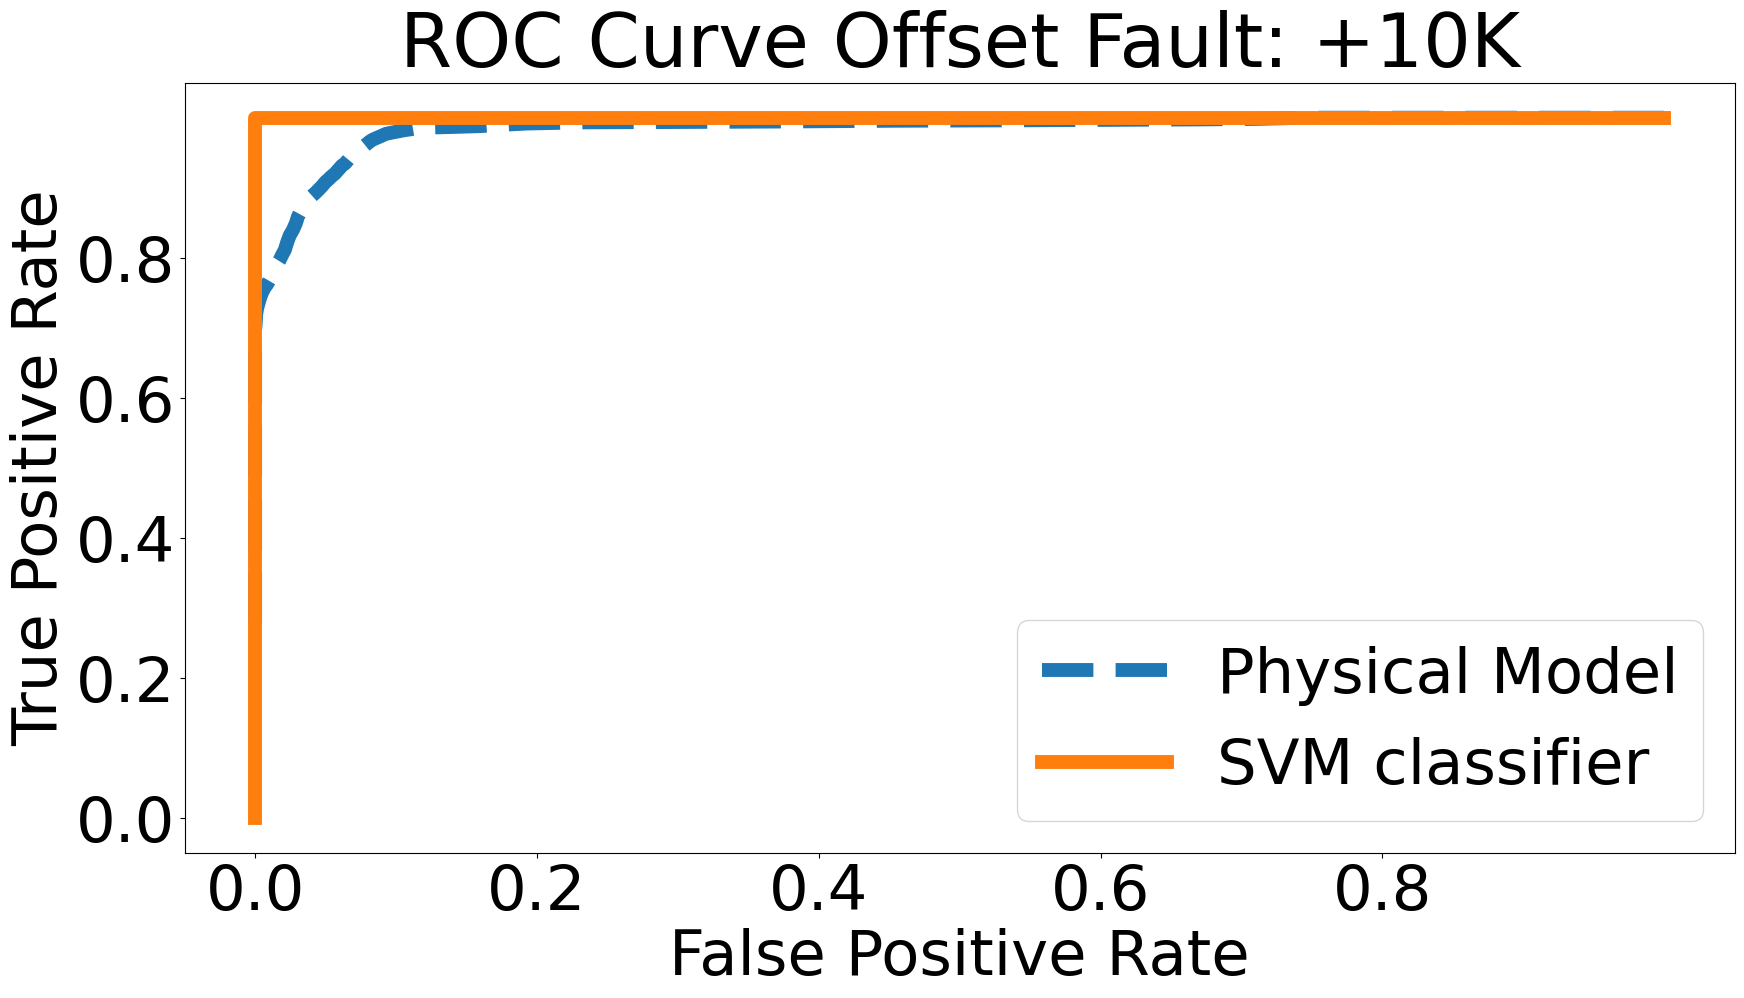

In [26]:
# f = class_fpr - 0.02
# t = class_tpr + 0.03
#print(ann_tpr)
plt.figure()
plt.rcParams.update({'font.size': 45})
plt.figure(figsize=(20,10))
plt.plot(phys_fpr[1], phys_tpr[1], linewidth = 10, label = "Physical Model",linestyle = '--')
#plt.plot(class_fpr, class_tpr, linewidth = 10, label = "SVM classifier")
#plt.plot(ann_fpr[2], ann_tpr[2], linewidth = 10, label = "SVR Model", linestyle=':', marker='o')
plt.xticks(np.arange(0, 1.0, step=0.2))
plt.yticks(np.arange(0, 1.0, step=0.2))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Offset Fault: +10K')
plt.legend(loc="lower right")
plt.show()